<a href="https://colab.research.google.com/github/compartia/creative/blob/master/snowflakes/notebooks/snowcode_recogition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

trainset_name = 'trainset_1_fixed_colors'
zip_name=f'{trainset_name}.zip'
trainset_url = f'https://github.com/compartia/creative/releases/download/v1.0.0/{zip_name}'

!wget $trainset_url
!unzip -q $zip_name

In [0]:
BASE = 6 # here we're dealing 6-ary encoding
MAX_DIGITS=128
IMAGE_SIZE=[255, 255, 3]

# Read and prepare trainset

In [0]:
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences

metadata = pd.read_csv(f'/content/{trainset_name}/metadata.csv')

In [0]:
def localize_fn(fn):
  return f'/content/{trainset_name}/' + fn.split('/')[-1]

## Prepare lables


### A) make float labels (Y) from integes `{0,1,2,...MAX} -> [0...1] == label/BASE` 

In [62]:
def convert_label(s:str)->[float]:
  return  [ float(c)/(BASE-1) for c in s ] 

print(convert_label(metadata['encoded6'][0]))

# Padding labels

labels = [convert_label(s) for s in metadata['encoded6']]
labels = pad_sequences(labels, maxlen=MAX_DIGITS, dtype='float32', padding='pre', truncating='pre', value=0.0)

[1.0, 0.8, 0.6, 0.4, 0.2, 0.6, 0.2, 1.0, 0.6, 0.4, 1.0, 0.2, 0.0, 0.0, 0.4, 1.0, 0.2, 0.4, 0.6, 0.8, 0.0, 1.0, 1.0, 0.8, 0.4, 1.0, 0.8, 0.6, 0.4, 0.8, 1.0, 0.6, 1.0, 0.8, 0.8, 0.6, 0.0, 1.0, 0.4, 0.8, 0.0, 0.4, 0.0, 0.8, 0.0, 0.4, 0.8, 0.6, 0.8, 0.2, 0.4, 0.0, 0.4, 0.2, 0.6, 1.0, 0.4, 0.6, 0.4, 0.6, 0.8, 0.6, 0.6, 0.8, 0.0, 1.0, 0.8, 0.6, 0.2, 0.4, 0.2, 0.6, 0.2, 1.0, 0.6, 1.0]


### B) "sparce" binary labels; WARN: this overwrites `label` var from prev. section
the idea is to convert "dense" 1D array of base-6 numbers (digits) into a "sparce" binary matrix of shape (None, 6) whrere each 1/0 row corresponds to a cerain digit occurance

101


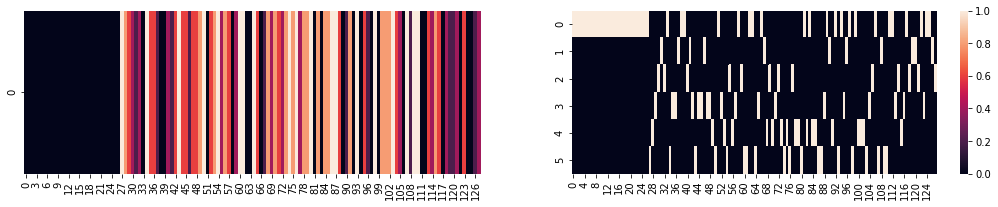

In [66]:

def digits2ints(digits:str) -> [int]:
  a =   [ int(c) for c in digits] 
  a = pad_sequences([a], maxlen=MAX_DIGITS, padding='pre', truncating='pre', value=0)
  return a[0]

def digits2matrix(digits:str):
  ints = digits2ints(digits)
  label_mtx = np.zeros( shape=(BASE, MAX_DIGITS)  )
  for i, v in enumerate(ints):
    label_mtx[v,i]=1
  
  return label_mtx


## plot  -----------
_digits = metadata['encoded6'][10]
print(len(_digits))
ints = digits2ints(_digits)
label_mtx = digits2matrix(_digits)


from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
 
 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 3))
 
sns.heatmap([ints], cmap="rocket", ax=ax1, cbar=False)  
sns.heatmap(label_mtx, cmap="rocket",  ax=ax2 )
 
plt.show()
 

In [67]:
labels = np.array([digits2matrix(s) for s in metadata['encoded6']])
labels.shape

(499, 6, 128)

## Trainset Generators, augmentation, etc..

In [7]:
import os

import numpy as np  
import pandas as pd  

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, SeparableConv2D, BatchNormalization, Input, Conv2D, GlobalAveragePooling2D,concatenate,Concatenate,multiply, LocallyConnected2D, Lambda, MaxPooling2D)
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.models import Model

import keras
print(f'keras version: {keras.__version__}')

from pathlib import Path


keras version: 2.3.1


In [0]:
metadata['image'] = [localize_fn(fn) for fn in metadata['filename'] ]

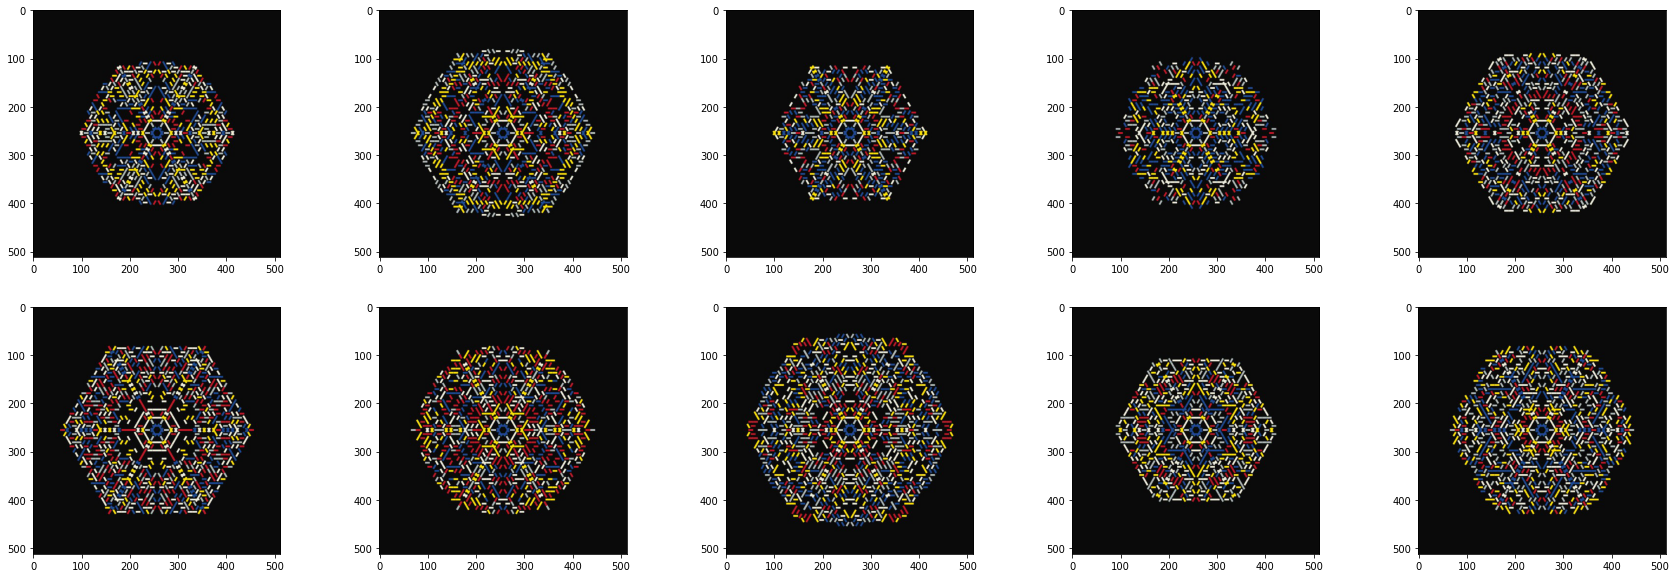

In [68]:
from PIL import Image
from skimage.io import imread
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg

f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(  metadata.loc[i, 'image'])
    ax[i//5, i%5].imshow(img) 
plt.show()

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

images_cache={}
def get_image(pth):
  # print(pth)

  if pth not in images_cache:
    image = load_img(pth, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]))
    image = img_to_array(image)
    images_cache[pth] = image
  
  return images_cache[pth]
  

img = get_image(metadata.image[1])

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


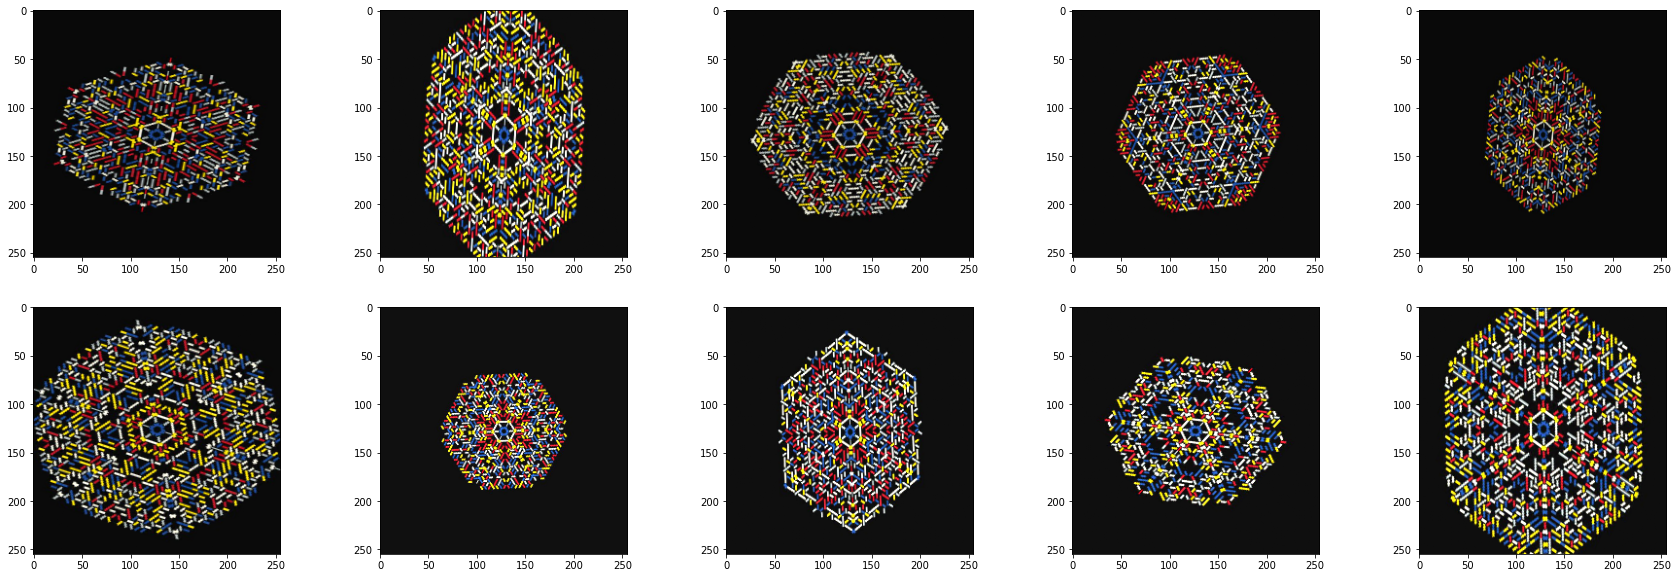

In [70]:



_dataset = list(zip(metadata.image.values, labels ))

test_dataset=_dataset[0:100]
train_dataset=_dataset[100:]

datagen = ImageDataGenerator(
    # rescale= 1./255.,    
    rotation_range=120, 
    zoom_range=0.3, 
    zca_whitening=True,
    shear_range=0.2, 
    brightness_range=[0.7,1.7]
    )

 



def get_generator( batch_size, _dataset):
  while True:
    # Select files (paths/indices) for the batch
    idx = np.random.randint(len(_dataset), size=batch_size)

    batch_input = []
    batch_output = []

    # Read in each input, perform preprocessing and get labels
    for i in idx:
      pair = _dataset[i]
      img = get_image(pair[0] )
      img =  datagen.random_transform(img)/255.
      label =  pair[1]      

      batch_input.append(img)
      batch_output.append(label)
 
    batch_x = np.array(batch_input)
    batch_y = np.array(batch_output)

    yield (batch_x, batch_y)


 
train_gen = get_generator(10, train_dataset );
test_gen = get_generator(10, test_dataset );
 
for k in range(1):
  # Plot the data 
  f, ax = plt.subplots(2,5, figsize=(30,10))

  images, labels = next(test_gen)
 
  for i in range(10):
    img = images[i]  
    ax[i//5, i%5].imshow(img ) 
  plt.show()

# The model

In [0]:
!pip install -U efficientnet

### TODO: Define custom stepped activation function for dense label matrices
will be used for Multi-label classification  


\begin{equation*}
X-\frac{    \sin\left(2 \pi n \cdot X \right)}{2\pi n}
\end{equation*}

where n = BASE


In [0]:
# Define custom loss
import keras.backend as K
 
import math

_2PI_N:float=math.pi*2*BASE 
def stepped_activation(X):
  return x - (K.sin(x *_2PI_N)/_2PI_N)


def mse_on_integers(y_true, y_pred):
  #XXX: does not work!! because K.round has no gradients
  return K.mean(K.square(K.round(y_pred*BASE) - K.round(y_true*BASE)), axis=-1)

In [0]:
#

### Building graph on top of Efficientnet

In [0]:
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Flatten, Reshape, Softmax
from keras import Model

import efficientnet.keras as efn 


base_model = efn.EfficientNetB4(weights='noisy-student', include_top=False)
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)  
# x = Flatten()(x)  
# x = Dense(128, activation='relu')(x)

x = Dense(MAX_DIGITS*BASE, activation='sigmoid')(x)
x = Reshape( (BASE, MAX_DIGITS) ) (x)
x = Softmax(axis=-2) (x)
model = Model(inputs=base_model.input, outputs=x)

# fix the feature extraction part of the model
for layer in base_model.layers:
    layer.trainable = True
 

# model.compile(optimizer='Nadam', loss=mse_on_integers, metrics=['categorical_accuracy'])
# model.compile(optimizer='Nadam', loss='mean_squared_error', metrics=['categorical_accuracy'])
model.compile(optimizer='Nadam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

In [117]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
 

es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)

history = model.fit_generator(generator=train_gen,
                    steps_per_epoch=500, 
                    validation_data=test_gen,
                    validation_steps=3,
                    epochs=15,                           
                 
                    callbacks = [es, chkpt],              
                    verbose=1)

Epoch 1/15
500/500 [==============================] - 213s 426ms/step - loss: 91.6920 - categorical_accuracy: 0.3490 - val_loss: 95.2007 - val_categorical_accuracy: 0.5000
Epoch 2/15
500/500 [==============================] - 211s 422ms/step - loss: 91.6429 - categorical_accuracy: 0.3414 - val_loss: 95.4630 - val_categorical_accuracy: 0.5278
Epoch 3/15
500/500 [==============================] - 212s 423ms/step - loss: 91.3228 - categorical_accuracy: 0.3502 - val_loss: 94.7474 - val_categorical_accuracy: 0.5000
Epoch 4/15
500/500 [==============================] - 211s 423ms/step - loss: 91.0554 - categorical_accuracy: 0.3415 - val_loss: 93.6030 - val_categorical_accuracy: 0.5944
Epoch 5/15
500/500 [==============================] - 212s 423ms/step - loss: 91.2823 - categorical_accuracy: 0.3342 - val_loss: 94.8491 - val_categorical_accuracy: 0.4722
Epoch 6/15
500/500 [==============================] - 212s 424ms/step - loss: 90.9534 - categorical_accuracy: 0.3688 - val_loss: 93.3701 - v

# Analyse (predict) single augmented iname


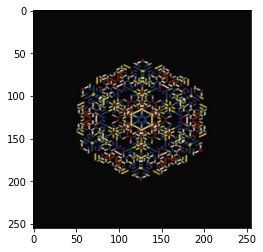

In [119]:
SAMPLE_INDEX=12

_digits = metadata['encoded6'][SAMPLE_INDEX]
label_mtx = digits2matrix(_digits)


img = get_image(metadata.image[SAMPLE_INDEX])
img =  datagen.random_transform(img)/255.
plt.imshow(img) 

1.0000000894069672


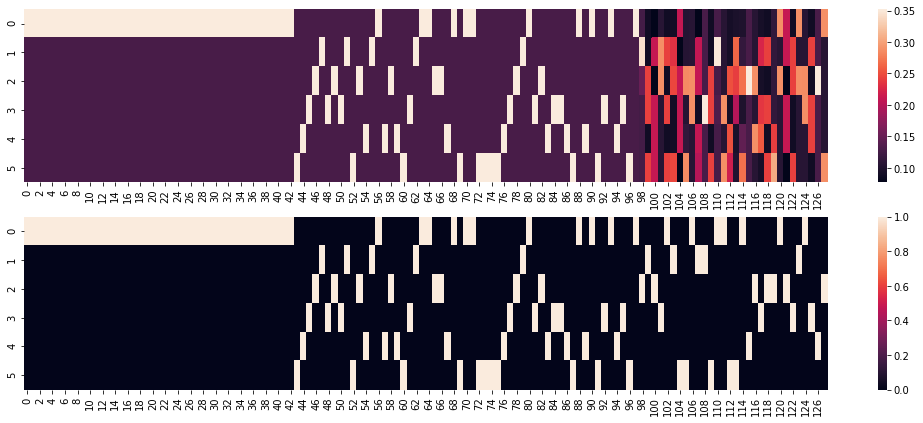

In [140]:
p=model.predict( np.array([img]) )[0]
print(sum(p.T[0])) #verify column sum is 1.
 
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(18, 7))
 
sns.heatmap(p, cmap="rocket", ax=ax1 )  
sns.heatmap(label_mtx, cmap="rocket",  ax=ax2 )
 
plt.show()

# decoding base6 encoded data

In [141]:
def restore_data(base6_encoded_string):
  a = int(base6_encoded_string, 6)
  b = a.to_bytes(128, byteorder='big')
  return b.decode("utf-8").replace('\x00','')



#-----------------TEST
if False:
  img = get_image(metadata.image[1])
  img =  datagen.random_transform(img)/255.
  p = model.predict( np.array([img, img]) )
  p[0]*5
  pc = [ int(round(v)) for v in p[0]*5 ]
  print(''.join(pc))
  print(metadata['encoded6'][1])


restore_data('431314044000115030505552302251520533005520512545202255454151215111544352332225525313414045113521001312220225')

'm|йFolamerando|йJameson|+36808329'